### Imports

In [1]:
## Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Pandas
import pandas as pd
pd.set_option('mode.chained_assignment',None)
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

## Numpy & Scikit-learn
import numpy as np
from sklearn import ensemble
from sklearn import metrics

## other python imports
import itertools

In [2]:
## Load training and testing datasets
## Obtain them from https://www.kaggle.com/c/how-much-did-it-rain-ii/data
## and put them in the same directory as this jupyter notebook

train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

# 1. Split the data into categories
My approach is to use boosted regression trees to predict the rain gauge measurements from the radar data. Boosted regression trees do best with a fair amount of thought going into feature engineering. The data is thus organized in 5 categories, which all differ in the availability of the features provided by the dataset. Having specialized boosted trees treat each category using only the features that are available is a feature engineering strategy as well as a data cleaning strategy. The categories are:

   * **Polarized:** No missing values for all features, for all entries in the time series.
   * **Basic:** No missing values for reflectivity features only, polarization features consistently missing.
   * **Null:** All values are missing for all entries in the time series.
   * **Partial Polarized:** At least some values missing in both reflectivity and polarization features.
   * **Partial Basic:** All polarized features are missing, at least some values missing in reflectivity features.
   
Entries where main reflectivity values are missing are ignored in the evaluation of the leaderboard score.

A Splitter class is written to split the training and testing datasets consistently.

In [3]:
## Define convenient groups of columns
all_columns = [
    'Ref',
    'Ref_5x5_10th',
    'Ref_5x5_50th',
    'Ref_5x5_90th',
    'RefComposite',
    'RefComposite_5x5_10th',
    'RefComposite_5x5_50th',
    'RefComposite_5x5_90th',
    'RhoHV',
    'RhoHV_5x5_10th',
    'RhoHV_5x5_50th',
    'RhoHV_5x5_90th',
    'Zdr',
    'Zdr_5x5_10th',
    'Zdr_5x5_50th',
    'Zdr_5x5_90th',
    'Kdp',
    'Kdp_5x5_10th',
    'Kdp_5x5_50th',
    'Kdp_5x5_90th'
]

basic_columns = all_columns[:8]
polarized_columns = all_columns[8:]

In [4]:
## ========================================
class Splitter:
    """
    A tool class to split both training and testing datasets into the 5 categories
    according to the exact same rules
    """


    ## ------------------------------------------
    def __init__(self, dataframe):
        """
        Constructor
        """

        self.df = dataframe

        ## Transform the dataset into booleans, indicating True for present values
        ## and false for missing values
        self.bool_df = self.df.notnull()
        self.bool_df['Id'] = self.df['Id']

        ## Collapse the time series in two different ways:
        ##     all: all values in time are present
        ##     any: any one value in time is present
        ##
        ## from these we can derive:
        ##     not any: no value is present

        all_df = self.bool_df.groupby('Id').agg(np.all)
        any_df = self.bool_df.groupby('Id').agg(np.any)

        self.ref_mask           = any_df['Ref']

        self.basic_all_mask     = all_df[basic_columns].all(axis=1)
        self.polarized_all_mask = all_df[polarized_columns].all(axis=1)

        self.basic_null_mask     = ~any_df[basic_columns].any(axis=1)
        self.polarized_null_mask = ~any_df[polarized_columns].any(axis=1)

        self.basic_partial_mask     = ~self.basic_null_mask & ~self.basic_all_mask
        self.polarized_partial_mask = ~self.polarized_null_mask & ~self.polarized_all_mask


    ## -------------------------------------------
    def polarized(self):
        """
        Guarantees complete information
        """

        return self.df[self.df['Id'].map(self.basic_all_mask & self.polarized_all_mask)]


    ## -------------------------------------------
    def basic(self):
        """
        Guarantees complete information for the reflectivity, but incomplete or
        absent information for the polarization values
        """

        return self.df[self.df['Id'].map(self.basic_all_mask & self.polarized_null_mask)]


    ## -------------------------------------------
    def null(self):
        """
        Gurantees that no information is present
        """

        return self.df[self.df['Id'].map(self.basic_null_mask | ~self.ref_mask)]


    ## --------------------------------------------
    def partial_basic(self):
        """
        Gurantees that only a fraction of the reflectivity data is available
        """

        return self.df[self.df['Id'].map(self.ref_mask & self.basic_partial_mask & self.polarized_null_mask)]


    ## --------------------------------------------
    def partial_polarized(self):
        """
        Guarantees that at least some basic information is present,
        and that only a partial set of polarization information is present
        """

        cross = self.basic_partial_mask | self.polarized_partial_mask
        none  = self.basic_null_mask | self.polarized_null_mask

        return self.df[self.df['Id'].map(self.ref_mask & cross & ~none)]

In [5]:
## Pass the datasets to the splitters
train_splt = Splitter(train_df)
test_splt  = Splitter(test_df)

In [6]:
## Obtain the split datasets
polarized_df         = train_splt.polarized()
basic_df             = train_splt.basic()
null_df              = train_splt.null()
partial_basic_df     = train_splt.partial_basic()
partial_polarized_df = train_splt.partial_polarized()

In [7]:
## Ensure the resulting groups are both inclusive and exclusive
n_complete = len(train_df)

n_polarized = len(polarized_df)
print 'Polarized DF               :', n_polarized, '({:.2%})'.format(float(n_polarized)/n_complete)

n_basic = len(basic_df)
print 'Basic DF                   :', n_basic, '({:.2%})'.format(float(n_basic)/n_complete)

n_null = len(null_df)
print 'Null DF                    :', n_null, '({:.2%})'.format(float(n_null)/n_complete)

n_partial_basic = len(partial_basic_df)
print 'Partial Basic DF           :', n_partial_basic, '({:.2%})'.format(float(n_partial_basic)/n_complete)

n_partial_polarized = len(partial_polarized_df)
print 'Partial Polarized DF       :', n_partial_polarized, '({:.2%})'.format(float(n_partial_polarized)/n_complete)

print '-'*47
n_all = n_polarized + n_basic + n_null + n_partial_basic + n_partial_polarized
print 'Putting them back together :', n_all, '({:.2%})'.format(float(n_all)/n_complete)

print 'Complete DF                :', n_complete

Polarized DF               : 1085817 (7.89%)
Basic DF                   : 160618 (1.17%)
Null DF                    : 4639872 (33.71%)
Partial Basic DF           : 1585333 (11.52%)
Partial Polarized DF       : 6293561 (45.72%)
-----------------------------------------------
Putting them back together : 13765201 (100.00%)
Complete DF                : 13765201


# 2. Data cleaning and time-series integration
There are 5 features provided in this dataset, and for each feature, the value in the air column right above the rain gauge is what I will call the main value. The 10th, 50th and 90th quantile of the distribution of values in a 5x5 grid around the rain gauge are also provided, and I use them to do a very simple linear extrapolation and guess the main value when it is missing.

The reflectivity is related to the rate of precipitation. Therefore, in order to obtain a cumulative amount, the reflectivity should be integrated over time. The resulting number is hopefully proportional to the total amount of rain on the ground during the hour. Since the number of entries in each time series vary, the total number of features usable for each rain gauge prediction varies as well. This is innapropriate for boosted regression trees, as a constant number of input features is expected. The time series are then boiled down to single numbers. The reflectivities are integrated, and the polarimetric features are averaged.

In [8]:
## Calculate extrapolation factors from distributions to main values for the reflectivities and RhoHV
## Simply calculate the ratio of the means using the polarized DF

Ref   = np.nanmean(polarized_df['Ref'].values)
Ref10 = np.nanmean(polarized_df['Ref_5x5_10th'].values)
Ref50 = np.nanmean(polarized_df['Ref_5x5_50th'].values)
Ref90 = np.nanmean(polarized_df['Ref_5x5_90th'].values)

RefComposite   = np.nanmean(polarized_df['RefComposite'].values)
RefComposite10 = np.nanmean(polarized_df['RefComposite_5x5_10th'].values)
RefComposite50 = np.nanmean(polarized_df['RefComposite_5x5_50th'].values)
RefComposite90 = np.nanmean(polarized_df['RefComposite_5x5_90th'].values)

RhoHV   = np.nanmean(polarized_df['RhoHV'].values)
RhoHV10 = np.nanmean(polarized_df['RhoHV_5x5_10th'].values)
RhoHV50 = np.nanmean(polarized_df['RhoHV_5x5_50th'].values)
RhoHV90 = np.nanmean(polarized_df['RhoHV_5x5_90th'].values)

cf = {
    'Ref'          : (Ref/Ref50,                   Ref/Ref10,                   Ref/Ref90),
    'RefComposite' : (RefComposite/RefComposite50, RefComposite/RefComposite10, RefComposite/RefComposite90),
    'RhoHV'        : (RhoHV/RhoHV50,               RhoHV/RhoHV10,               RhoHV/RhoHV90)
}

In [9]:
## -------------------------------------------
def complete_main_values(df, columns=[]):
    """
    Completes the main variables using the distributions
    """
    
    for var in columns:
        df[var] = df[var].fillna(value=cf[var][0]*df['{0}_5x5_50th'.format(var)])
        df[var] = df[var].fillna(value=cf[var][1]*df['{0}_5x5_10th'.format(var)])
        df[var] = df[var].fillna(value=cf[var][2]*df['{0}_5x5_90th'.format(var)])

In [10]:
## Define a function to assign a time interval to each time series entry
## which will be used to do a coarse rectangular integration

## -------------------------------------------
def intervals(df):
    """
    Adds a column to the dataframe assigning a time interval for each entry
    """
    
    df['interval'] = df['minutes_past'].diff()
    
    ## Build two masks, to single out first and last rows of each group
    group_begin_mask = df['Id'].diff() != 0
    group_end_mask   = df['Id'].diff().shift(-1) != 0
    
    ## Patch the beginning entry of each group
    df['interval'][group_begin_mask] = df['minutes_past'][group_begin_mask]
    
    ## Patch the last entry of each group
    df['interval'][group_end_mask] = 60 + df['interval'][group_end_mask] - df['minutes_past'][group_end_mask]

In [11]:
## Write a class to collapse the time series according to given instructions
## The option to super_integrate replace the main values by an average value
## of the main value, the 10th, the 50th and th 90th quantiles. It seems to
## make the predictions a little more accurate in some categories. One possible
## reason for this is the motion of the clouds. A single radar reading is a
## snapshot in time, but between the readings, the clouds move. Between two
## separate readings, the clouds above the rain gauge are not going to be
## exactly the same as at the time of the readings. It might matter to take the
## 5x5 distributions to account for cloud motion, but it can't be very precise.
## This is why I don't bother doing more than this very crude accounting of
## the 5x5 distributions. Ideally, You would have the actual readings in the 5x5
## grid, and you could interpolate what cloud region was above the rain gauge
## at any instant. The quantiles simply do not hold the information to do this.

## ========================================
class Collapser:
    """
    A class to collapse the time series
    """

    ## -------------------------------------------
    def __init__(self, integrate=[], mean=all_columns, patch=[], super_integrate=False):
        """
        Constructor
        """

        self.integrate = integrate
        self.super_integrate = super_integrate
        self.mean = list(set(mean).difference(set(integrate)))
        self.patch = patch


    ## -------------------------------------------
    def collapse(self, df):
        """
        Collapse the time series for a dataset given the rules
        specified in the constructor
        """

        intervals(df)
        complete_main_values(df, self.patch)

        int_columns = []
        
        ## Multiply the quantities by the time intervals
        for var in self.integrate:
            name = 'Int_{0}'.format(var)
            df[name] = df['interval'] * df[var]
            int_columns.append(name)
            
        ## Different values need to be grouped in different ways
        try:
            expected  = df[['Id', 'Expected', 'radardist_km'] + self.mean]
        except KeyError:
            expected  = df[['Id', 'radardist_km'] + self.mean]
            
        expected  = expected.groupby('Id', as_index=False).mean()
    
        variables = df[['Id'] + int_columns]
        variables = variables.groupby('Id', as_index=False).sum()
        
        ## Fold the 5x5 distributions into the integration
        if self.super_integrate:
            if 'Ref' in self.integrate:
                variables['Int_Ref'] = variables['Int_Ref'] + \
                variables['Int_Ref_5x5_10th'] + \
                variables['Int_Ref_5x5_50th'] + \
                variables['Int_Ref_5x5_90th']
                
            if 'RefComposite' in self.integrate:
                variables['Int_RefComposite'] = variables['Int_Ref'] + \
                variables['Int_RefComposite_5x5_10th'] + \
                variables['Int_RefComposite_5x5_50th'] + \
                variables['Int_RefComposite_5x5_90th']
                
            if 'RhoHV' in self.integrate:
                variables['Int_RhoHV'] = variables['Int_Ref'] + \
                variables['Int_RhoHV_5x5_10th'] + \
                variables['Int_RhoHV_5x5_50th'] + \
                variables['Int_RhoHV_5x5_90th']
                
            if 'Zdr' in self.integrate:
                variables['Int_Zdr'] = variables['Int_Ref'] + \
                variables['Int_Zdr_5x5_10th'] + \
                variables['Int_Zdr_5x5_50th'] + \
                variables['Int_Zdr_5x5_90th']
                
            if 'Kdp' in self.integrate:
                variables['Int_Kdp'] = variables['Int_Ref'] + \
                variables['Int_Kdp_5x5_10th'] + \
                variables['Int_Kdp_5x5_50th'] + \
                variables['Int_Kdp_5x5_90th']
        
        ## transform the integrated values into average rates
        for var in int_columns:
            if self.super_integrate:
                variables[var] = variables[var]/240.0
            else:
                variables[var] = variables[var]/60.0
            
        ## Rename columns to what they are supposed to be
        renamer = {}
        for original, int_name in zip(self.integrate, int_columns):
            renamer[int_name] = original
            
        variables.rename(columns=renamer, inplace=True)
            
        ## Merge back expected and variables
        return pd.merge(variables, expected, on='Id')

In [12]:
## Run the collapsers on the training datasets

## Polarized DF : integrate the reflectivities, average the polarimetric features
polarized_collapser         = Collapser(integrate=basic_columns, super_integrate=True)
polarized_collapsed_df      = polarized_collapser.collapse(polarized_df)
test_polarized_collapsed_df = polarized_collapser.collapse(test_splt.polarized())

## Basic DF : integrate the reflectivities
basic_collapser         = Collapser(integrate=basic_columns, super_integrate=True)
basic_collapsed_df      = basic_collapser.collapse(basic_df)
test_basic_collapsed_df = basic_collapser.collapse(test_splt.basic())

## Null DF : doesn't really matter, just collapse the time series
null_collapser         = Collapser()
null_collapsed_df      = null_collapser.collapse(null_df)
test_null_collapsed_df = null_collapser.collapse(test_splt.null())

## Partial Polarized DF : patch the reflectivities, average the polarimetric features
partial_polarized_collapser         = Collapser(patch=['Ref', 'RefComposite'])
partial_polarized_collapsed_df      = partial_polarized_collapser.collapse(partial_polarized_df)
test_partial_polarized_collapsed_df = partial_polarized_collapser.collapse(test_splt.partial_polarized())

## Partial Basic DF : Only patch the composite Reflectivity, average everything else
partial_basic_collapser         = Collapser(patch=['RefComposite'])
partial_basic_collapsed_df      = partial_basic_collapser.collapse(partial_basic_df)
test_partial_basic_collapsed_df = partial_basic_collapser.collapse(test_splt.partial_basic())

In [13]:
## Write a function to clean repeat rain gauge values. Rain gauges can be stuck and result
## in erroneous data. These readings should be ignored while training the decision trees. Since
## these cases while also occur in the testing datasets, they will artificially drag down
## the score.

## ---------------------------------------
def clean_stuck_gauges(dataframe, threshold=50):
    """
    Remove rain gauge values that occur too often, indicating that those gauges are stuck
    """

    dataframe['count'] = 1
    counts = dataframe.groupby('Expected', as_index=False).count()
    large_counts = counts[counts['count'] > threshold]

    def high_count(expected):
        return len(large_counts[large_counts['Expected'] == expected]) > 0

    dataframe['large_count'] = map(high_count, dataframe['Expected'])
    clean_dataframe = dataframe[dataframe['large_count']]

    clean_dataframe.drop('count', 1)
    clean_dataframe.drop('large_count', 1)

    return clean_dataframe

# 3. Boosted regression tree training and prediction median adjustment

## 3.1. Polarized DF

In [14]:
## Split the training dataset in training and testing datasets for crude BRT optimization, but also to check the effect
## of doing additional data cleaning on the training dataset on the BRT performance

split = len(polarized_collapsed_df)/2
train = polarized_collapsed_df[:split]
test  = polarized_collapsed_df[split:]

In [15]:
## Write a class to train, store and apply a boosted regression tree
## The training dataset requires additional cleaning such as
##     1. Making sure no NaN values are left, replace with dummy value of -1111.0
##     2. Remove outliers. A meter of rain on the ground during 1h doesn't make much sense
##     3. Clean stuck gauges. If a specific value for a rain gauge prediction occurs too
##        often, remove all entries with that value from the training dataset
## ========================================

class BRTTrainer:
    """
    A class to train a Boosted Regression Trees
    """

    ## --------------------------------------------
    def __init__(self, train_df, variables=all_columns, max_depth=None, n_estimators=10, max_features=None):
        """
        Constructor
        """

        self.train_df = train_df
        self.brt = None
        self.variables = variables
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.max_features = max_features


    ## --------------------------------------------
    def train(self, clean=False, stuck_repeat=50, max_expected=100.0):
        """
        Train the BRT
        """

        ## Do some additional cleaning only on the training datasets
        clean_df = self.train_df.fillna(-1111.0)
        if clean:
            clean_df = clean_stuck_gauges(clean_df, threshold=stuck_repeat)
            clean_df = clean_df[clean_df['Expected'] < max_expected]

        ## Extract numpy arrays to pass to scikit-learn for training
        train_data   = clean_df[['radardist_km'] + self.variables].values
        train_target = clean_df['Expected'].values

        ## Train the Boosted Regression trees
        self.brt = ensemble.GradientBoostingRegressor(
            max_depth=self.max_depth,
            n_estimators=self.n_estimators,
            max_features=self.max_features,
            random_state=24)
        
        self.brt.fit(train_data, train_target)


    ## ---------------------------------------------
    def predict(self, *args):
        """
        Produce prediction for a single entry
        """

        return self.brt.predict(args)[0]


    ## ---------------------------------------------
    def apply(self, df):
        """
        Create a new prediction column for a dataset
        """

        clean_df = df.fillna(-1111.0)
        
        columns = [clean_df['radardist_km']]
        for var in self.variables:
            columns.append(clean_df[var])

        df['Prediction'] = map(self.predict, *columns)
        
        
    ## ---------------------------------------------
    def evaluate(self, df):
        """
        Evaluate the performance of the predictions
        This is the same metric used for the leaderboard
        """
        
        return metrics.mean_absolute_error(df['Expected'].values, df['Prediction'].values)

In [16]:
## Train a BRT on half the training dataset. Parameters have been roughly optimized by hand

polarized_trainer = BRTTrainer(train, variables=all_columns, max_depth=3, n_estimators=200)
polarized_trainer.train(clean=True, stuck_repeat=10, max_expected=20.0)

In [17]:
## Evaluate on the second half of the training dataset

polarized_trainer.apply(test)
polarized_trainer.evaluate(test)

10.146449621934311

In [18]:
## Create a class to make scatter plot matrices

## ========================================
class ScatterMatrix:
    """
    A class to create a matrix of scatter plots from a pandas data frame
    """
    
    ## ----------------------------------------
    def __init__(self, dataframe):
        """
        Constructor
        """
        
        self.data = dataframe
        
        self.n = 0
        self.variables = []
        self.labels = []
        self.lo = []
        self.hi = []
        
        
    ## ----------------------------------------
    def add(self, variable_name, lo=None, hi=None, label=None):
        """
        Add a variable to the matrix:
        'variable_name' is the name of the variable to plot as it appears in the data frame
        'label' is how the variable name should appear on the plot. If left unspecified, 'variable_name' will be used.
        'lo' is the lower bound to show for this variable. If left unspecifed, the minimum value will be used
        'hi' is the highest bound...
        """
        
        self.variables.append(variable_name)
        
        if label is None:
            label = variable_name
        self.labels.append(label)
        
        if lo is None:
            lo = self.data[variable_name].values.min()
        self.lo.append(lo)
        
        if hi is None:
            hi = self.data[variable_name].values.max()
        self.hi.append(hi)
        
        self.n += 1
        
        
    ## ----------------------------------------
    def plot(self):
        """
        produces the plot
        """
        
        fig, axes = plt.subplots(nrows=self.n, ncols=self.n, figsize=(2*self.n,2*self.n))
        fig.subplots_adjust(hspace=0.05, wspace=0.05)
        
        for i in range(self.n):
            for j in range(self.n):
                
                ## Put column j on the x-axis and column i on the y-axis
                if i != j: axes[i][j].hist2d(
                                        self.data[self.variables[j]].values, 
                                        self.data[self.variables[i]].values, 
                                        cmap=plt.cm.YlOrRd_r,
                                        bins=[40,40],
                                        range=[[self.lo[j], self.hi[j]], [self.lo[i], self.hi[i]]]
                                        )
                    
                ## If i==j, display the feature name 
                else:
                    
                    axes[i][j].set_axis_bgcolor('white')
                    for spine in axes[i][j].spines.values():
                        spine.set_edgecolor('white')
                    
                    axes[i][j].annotate(
                                self.labels[i],
                                (0.5, 0.5),
                                xycoords='axes fraction',
                                ha='center',
                                va='center'
                                )
                    
                ## Hide axis labels strategically
                axes[i][j].xaxis.set_visible(False)
                axes[i][j].yaxis.set_visible(False)
                axes[i][j].grid(False)
                
                if (i == self.n -1) and (j%2 == 0):
                    axes[i][j].xaxis.set_ticks_position('bottom')
                    axes[i][j].xaxis.set_visible(True)
                    
                if (i == 0) and (j%2-1 == 0):
                    axes[i][j].xaxis.set_ticks_position('top')
                    axes[i][j].xaxis.set_visible(True)
                    
                if (j == self.n -1) and (i%2 == 0):
                    axes[i][j].yaxis.set_ticks_position('right')
                    axes[i][j].yaxis.set_visible(True)
                    
                if (j == 0) and (i%2-1 == 0):
                    axes[i][j].yaxis.set_ticks_position('left')
                    axes[i][j].yaxis.set_visible(True)
            
        plt.show()

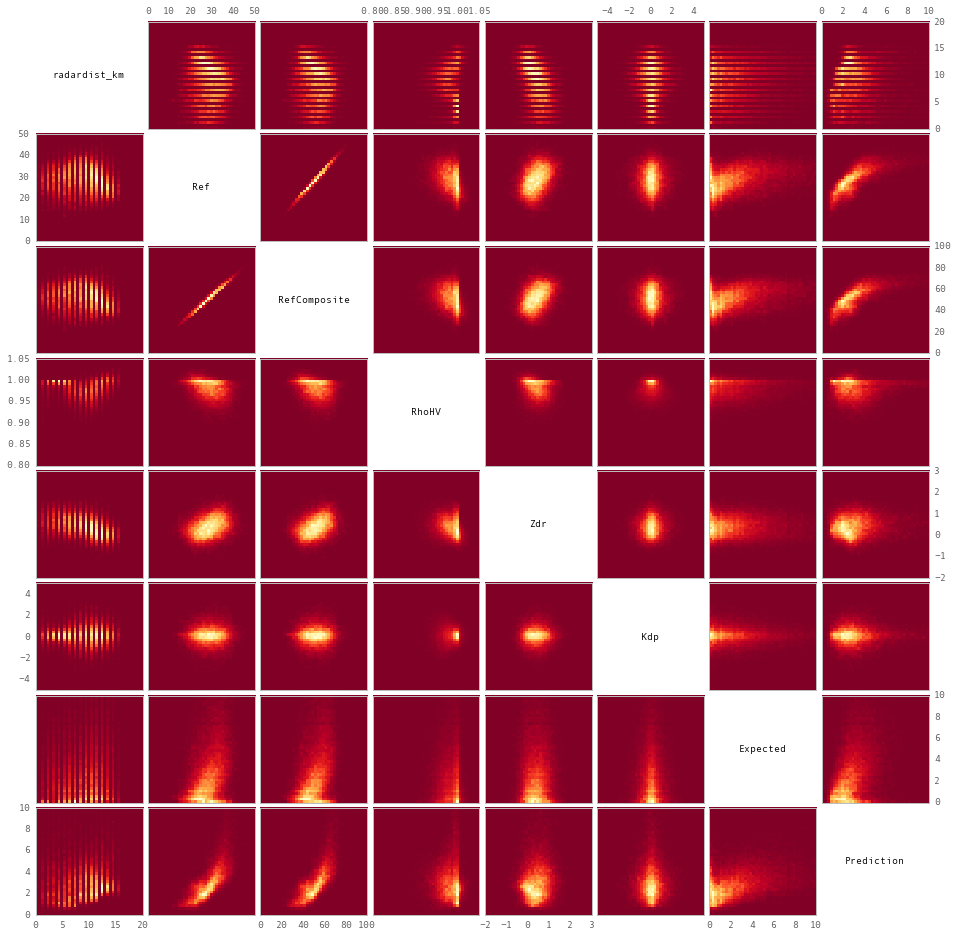

In [19]:
## Make a scatter plot matrix for the Polarized DF
sm = ScatterMatrix(test)
sm.add('radardist_km', 0, 20)
sm.add('Ref', 0, 50)
sm.add('RefComposite', 0, 100)
sm.add('RhoHV', 0.8, 1.05)
sm.add('Zdr', -2,3)
sm.add('Kdp', -5, 5)
sm.add('Expected', 0, 10)
sm.add('Prediction', 0, 10)
sm.plot()

It's interesting to look at the correlation between the two types of reflectivity and the prediction. This correlation appears much stronger than it should be, given how strong the correlation is between the reflectivities and the expected values. What it means is that there really isn't much to go on in the other variables.

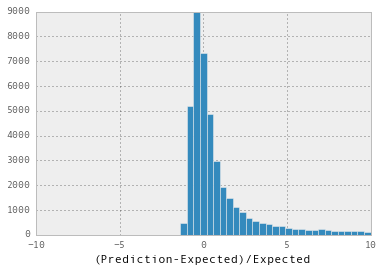

Resolution median: 0.228008315135


In [20]:
## Make a plot of the prediction resolution, and check the median of the distribution

## Compute resolution
resolution = (test['Prediction'] - test['Expected'])/test['Expected']

## Compute resolution histogram
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

## Make the plot
plt.bar(center, hist, align='center', width=width)
plt.xlabel('(Prediction-Expected)/Expected', fontsize=12, color='black')
plt.show()
print 'Resolution median:', resolution.median()

We see that the resolution plot isn't peaked at 0 as we would expect, and it has a rather large high tail. The BRT model tends to overestimate the amount of rain.

In [21]:
## The mean absolute error averages the differences between predictions and target. A small shift in the prediction
## can improve the resulting mean absolute error, resulting in a better position on the leaderboard. The scientific
## justification for this however is dubious at best. But this is the kind of thing the Kaggle format encourages
## you to do...

## ---------------------------------------------
def find_best_prediction_shift(test_df, trainer):
    """
    Finds the best score shift
    """
    min_score  = float('inf')
    best_shift = None

    for shift in [0.001*i for i in range(1001)]:
        test_df['backup'] = test_df['Prediction']
        test_df['Prediction'] = test_df['Prediction'] - shift
        score = trainer.evaluate(test_df)
        if score < min_score:
            min_score = score
            best_shift = shift
        test_df['Prediction'] = test_df['backup']
    
    return min_score, best_shift

In [22]:
## Find the best shift for the polarized BRT

min_score, best_shift = find_best_prediction_shift(test, polarized_trainer)
print min_score, best_shift

10.1072473288 0.439


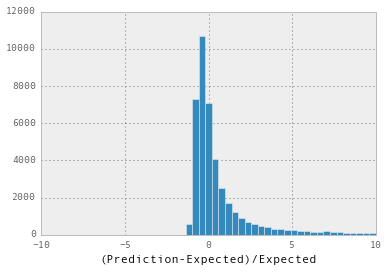

Resolution median: -0.00033836225406


In [23]:
## Again, make a plot of the prediction resolution, and check the median of the distribution
## after shifting by the value that was just found

## Apply the shift 
test['Prediction'] = test['Prediction'] - best_shift

## Compute resolution
resolution = (test['Prediction'] - test['Expected'])/test['Expected']

## Compute resolution histogram
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

## Make the plot
plt.bar(center, hist, align='center', width=width)
plt.xlabel('(Prediction-Expected)/Expected', fontsize=12, color='black')
plt.show()
print 'Resolution median:', resolution.median()

We now see that the peak of the distribution is closer to 0, and the median is pretty much at 0 now.

In [24]:
## Let's train on the entire training dataset now, and finalize our predictions for the Polarized DF.

polarized_trainer = BRTTrainer(
    polarized_collapsed_df,
    variables=all_columns,
    max_depth=3,
    n_estimators=200
    )

polarized_trainer.train(
    clean=True,
    stuck_repeat=10,
    max_expected=20.0
    )

polarized_trainer.apply(test_polarized_collapsed_df)
test_polarized_collapsed_df['Prediction'] = test_polarized_collapsed_df['Prediction'] - best_shift

## 3.1. Basic DF

In [25]:
## Split the training dataset in training and testing datasets for crude BRT optimization, but also to check the effect
## of doing additional data cleaning on the training dataset on the BRT performance

split = len(basic_collapsed_df)/2
train = basic_collapsed_df[:split]
test  = basic_collapsed_df[split:]

In [26]:
## Train a BRT on half the training dataset. Parameters have been roughly optimized by hand

basic_trainer = BRTTrainer(train, variables=basic_columns, max_depth=3, n_estimators=100)
basic_trainer.train(clean=True, stuck_repeat=10, max_expected=30.0)

In [27]:
## Evaluate on the second half of the training dataset

basic_trainer.apply(test)
basic_trainer.evaluate(test)

15.419431051322885

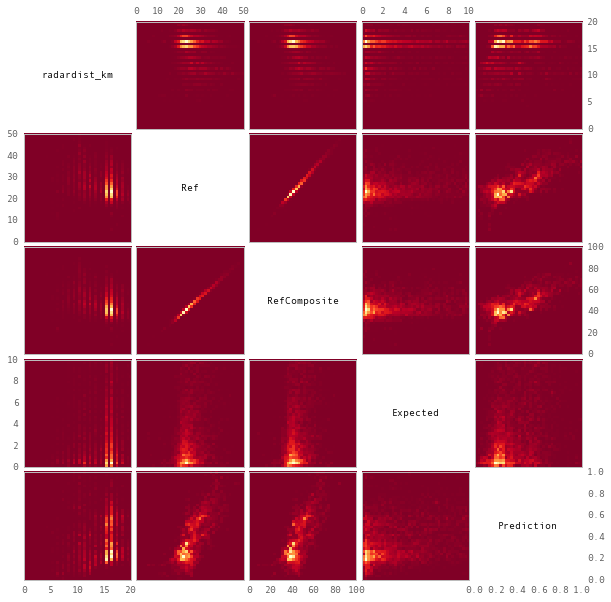

In [28]:
## Make a scatter plot matrix for the Basic DF
sm = ScatterMatrix(test)
sm.add('radardist_km', 0, 20)
sm.add('Ref', 0, 50)
sm.add('RefComposite', 0, 100)
sm.add('Expected', 0, 10)
sm.add('Prediction', 0, 10)
sm.plot()

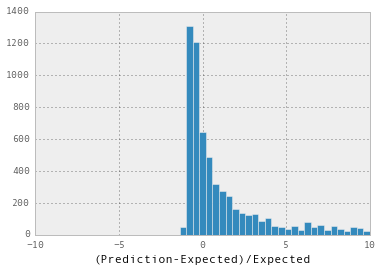

Resolution median: 0.247590693819


In [29]:
## Make a plot of the prediction resolution, and check the median of the distribution

## Compute resolution
resolution = (test['Prediction'] - test['Expected'])/test['Expected']

## Compute resolution histogram
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

## Make the plot
plt.bar(center, hist, align='center', width=width)
plt.xlabel('(Prediction-Expected)/Expected', fontsize=12, color='black')
plt.show()
print 'Resolution median:', resolution.median()

In [30]:
## Find the best shift for the basic BRT

min_score, best_shift = find_best_prediction_shift(test, basic_trainer)
print min_score, best_shift

15.3890832465 0.488


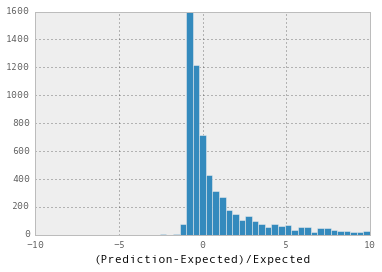

Resolution median: 2.83027041625e-05


In [31]:
## Again, make a plot of the prediction resolution, and check the median of the distribution
## after shifting by the value that was just found

## Apply the shift 
test['Prediction'] = test['Prediction'] - best_shift

## Compute resolution
resolution = (test['Prediction'] - test['Expected'])/test['Expected']

## Compute resolution histogram
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

## Make the plot
plt.bar(center, hist, align='center', width=width)
plt.xlabel('(Prediction-Expected)/Expected', fontsize=12, color='black')
plt.show()
print 'Resolution median:', resolution.median()

In [32]:
## Let's train on the entire training dataset now, and finalize our predictions for the Basic DF.

basic_trainer = BRTTrainer(
    basic_collapsed_df,
    variables=basic_columns,
    max_depth=3,
    n_estimators=100
    )

basic_trainer.train(
    clean=True,
    stuck_repeat=10,
    max_expected=30.0
    )

basic_trainer.apply(test_basic_collapsed_df)
test_basic_collapsed_df['Prediction'] = test_basic_collapsed_df['Prediction'] - best_shift

## 3.3. Null DF

The Null DF has no usable input data, so we'll simply use the median Expected value as the prediction. It doesn't count on the leaderboard anyway.

In [33]:
## Split into training and testing, check what kind of accuracy we get with the median as the prediction

split = len(null_collapsed_df)/2
train = null_collapsed_df[:split]
test  = null_collapsed_df[split:]

test['Prediction'] = train['Expected'].median()

## Use the basic trainer to evaluate, the evaluate method is independent of the BRT anyway
basic_trainer.evaluate(test)

304.61961855912733

In [34]:
## Finalize the predictions for the Null DF

test_null_collapsed_df['Prediction'] = null_collapsed_df['Expected'].median()

## 3.4. Partial Polarized DF

In [35]:
## Split between training and testing datasets

split = len(partial_polarized_collapsed_df)/2
train = partial_polarized_collapsed_df[:split]
test  = partial_polarized_collapsed_df[split:]

In [36]:
## Train the BRT on the training half and evaluate

partial_polarized_trainer = BRTTrainer(train, variables=all_columns, max_depth=3, n_estimators=300)
partial_polarized_trainer.train(clean=True, stuck_repeat=100, max_expected=20.0)

partial_polarized_trainer.apply(test)
partial_polarized_trainer.evaluate(test)

20.595924666414341

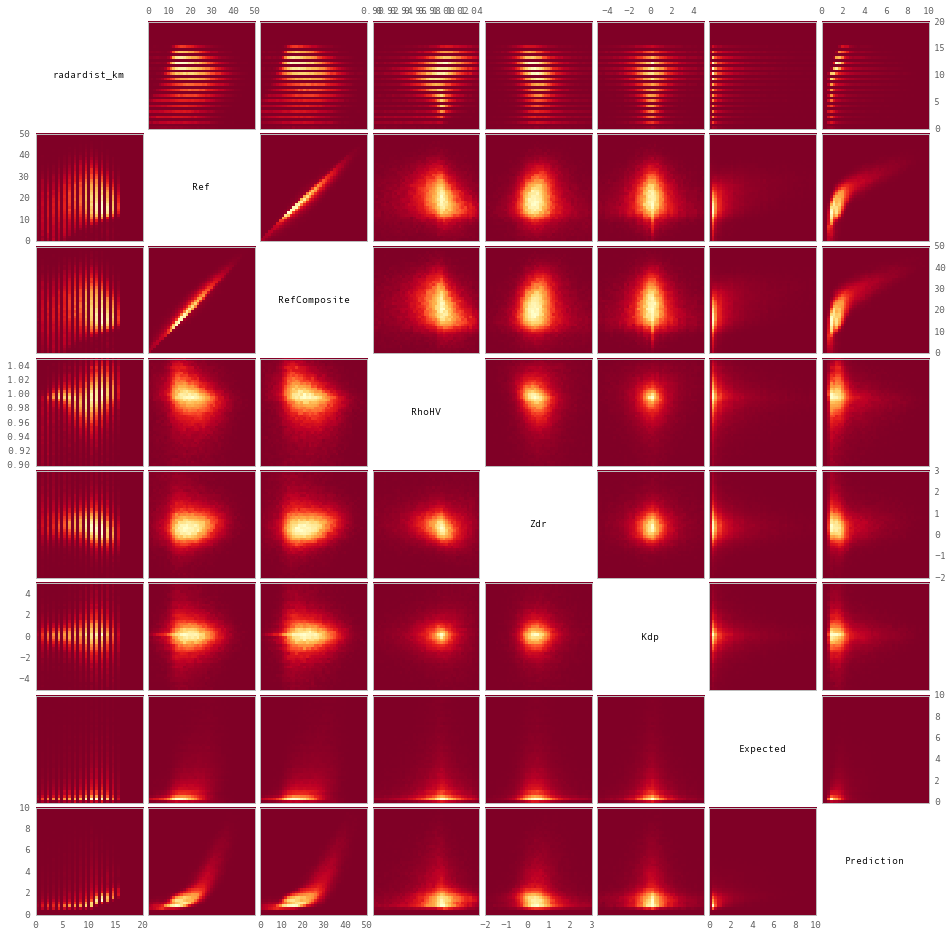

In [37]:
## Make a scatter plot matrix for the Polarized DF
sm = ScatterMatrix(test)
sm.add('radardist_km', 0, 20)
sm.add('Ref', 0, 50)
sm.add('RefComposite', 0, 50)
sm.add('RhoHV', 0.9, 1.05)
sm.add('Zdr', -2,3)
sm.add('Kdp', -5, 5)
sm.add('Expected', 0, 10)
sm.add('Prediction', 0, 10)
sm.plot()

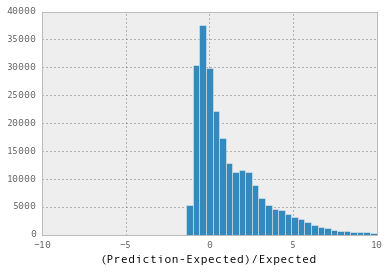

Resolution median: 0.606117498832


In [38]:
## Make a plot of the prediction resolution, and check the median of the distribution

## Compute resolution
resolution = (test['Prediction'] - test['Expected'])/test['Expected']

## Compute resolution histogram
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

## Make the plot
plt.bar(center, hist, align='center', width=width)
plt.xlabel('(Prediction-Expected)/Expected', fontsize=12, color='black')
plt.show()
print 'Resolution median:', resolution.median()

In [39]:
## Find the best shift for the polarized BRT

min_score, best_shift = find_best_prediction_shift(test, partial_polarized_trainer)
print min_score, best_shift

20.5133619627 0.488


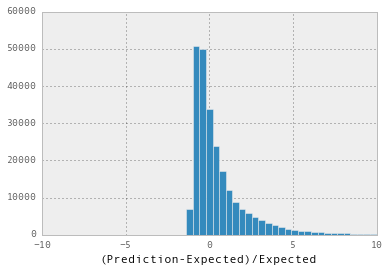

Resolution median: -0.000263254827757


In [40]:
## Again, make a plot of the prediction resolution, and check the median of the distribution
## after shifting by the value that was just found

## Apply the shift 
test['Prediction'] = test['Prediction'] - best_shift

## Compute resolution
resolution = (test['Prediction'] - test['Expected'])/test['Expected']

## Compute resolution histogram
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

## Make the plot
plt.bar(center, hist, align='center', width=width)
plt.xlabel('(Prediction-Expected)/Expected', fontsize=12, color='black')
plt.show()
print 'Resolution median:', resolution.median()

In [41]:
## Let's train on the entire training dataset now, and finalize our predictions for the Partial Polarized DF.

partial_polarized_trainer = BRTTrainer(
    partial_polarized_collapsed_df,
    variables=all_columns,
    max_depth=3,
    n_estimators=300
    )

partial_polarized_trainer.train(
    clean=True,
    stuck_repeat=100,
    max_expected=20.0
    )

partial_polarized_trainer.apply(test_partial_polarized_collapsed_df)
test_partial_polarized_collapsed_df['Prediction'] = test_partial_polarized_collapsed_df['Prediction'] - best_shift

## 3.5. Partial Basic DF

In [42]:
## Split between testing and training datasets, train and evaluate

split = len(partial_basic_collapsed_df)/2
train = partial_basic_collapsed_df[:split]
test  = partial_basic_collapsed_df[split:]

partial_basic_trainer = BRTTrainer(train, variables=basic_columns, max_depth=3, n_estimators=300)
partial_basic_trainer.train(clean=True, stuck_repeat=50, max_expected=20.0)

partial_basic_trainer.apply(test)
partial_basic_trainer.evaluate(test)

43.609777009322492

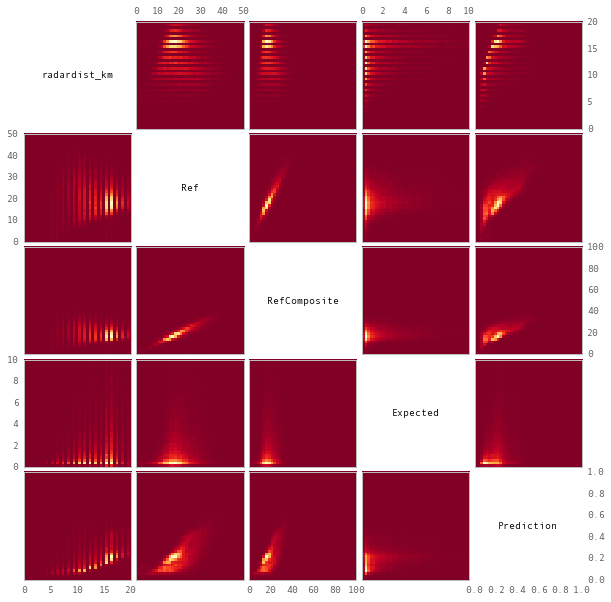

In [43]:
## Make a scatter plot matrix for the Partial Basic DF
sm = ScatterMatrix(test)
sm.add('radardist_km', 0, 20)
sm.add('Ref', 0, 50)
sm.add('RefComposite', 0, 100)
sm.add('Expected', 0, 10)
sm.add('Prediction', 0, 10)
sm.plot()

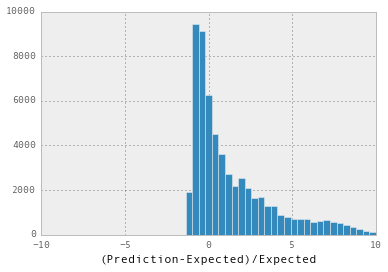

Resolution median: 0.539625347801


In [44]:
## Make a plot of the prediction resolution, and check the median of the distribution

## Compute resolution
resolution = (test['Prediction'] - test['Expected'])/test['Expected']

## Compute resolution histogram
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

## Make the plot
plt.bar(center, hist, align='center', width=width)
plt.xlabel('(Prediction-Expected)/Expected', fontsize=12, color='black')
plt.show()
print 'Resolution median:', resolution.median()

In [45]:
## Find the best shift for the polarized BRT

min_score, best_shift = find_best_prediction_shift(test, partial_basic_trainer)
print min_score, best_shift

43.5443718058 0.507


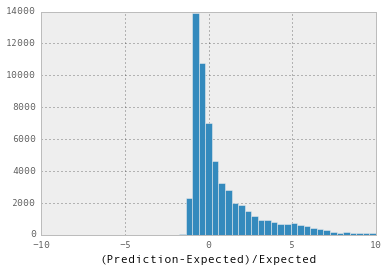

Resolution median: -0.000102231334026


In [46]:
## Again, make a plot of the prediction resolution, and check the median of the distribution
## after shifting by the value that was just found

## Apply the shift 
test['Prediction'] = test['Prediction'] - best_shift

## Compute resolution
resolution = (test['Prediction'] - test['Expected'])/test['Expected']

## Compute resolution histogram
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

## Make the plot
plt.bar(center, hist, align='center', width=width)
plt.xlabel('(Prediction-Expected)/Expected', fontsize=12, color='black')
plt.show()
print 'Resolution median:', resolution.median()

In [47]:
## Let's train on the entire training dataset now, and finalize our predictions for the Partial Polarized DF.

partial_basic_trainer = BRTTrainer(
    partial_basic_collapsed_df,
    variables=basic_columns,
    max_depth=3,
    n_estimators=300
    )

partial_basic_trainer.train(
    clean=True,
    stuck_repeat=50,
    max_expected=20.0
    )

partial_basic_trainer.apply(test_partial_basic_collapsed_df)
test_partial_basic_collapsed_df['Prediction'] = test_partial_basic_collapsed_df['Prediction'] - best_shift

# 4. Final results

In [48]:
## Concatenate the categories back into a single DF

test_dfs = [
    test_polarized_collapsed_df,
    test_basic_collapsed_df,
    test_null_collapsed_df,
    test_partial_polarized_collapsed_df,
    test_partial_basic_collapsed_df
]

test_with_predictions = pd.concat(test_dfs)

## Check that nothing was lost, expecting 717625 predictions
print 'Number of predictions:', len(test_with_predictions)

Number of predictions: 717625


In [49]:
## Produce the .csv predictions file
test_with_predictions.sort_values(by=['Id'], inplace=True)
test_with_predictions.rename(columns={'Prediction' : 'Expected'}, inplace=True)
test_with_predictions[['Id', 'Expected']].to_csv('predictions_final.csv', index=False)